# The Lorenz Attractor

### Predicting Trajectory/Shape

Attempt to use the Keras API to create a preceptron network to predict the shape of the model based of a known trajectory.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import metrics
from tensorflow.keras import losses, backend

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
plt.style.use("astro") # 
%matplotlib inline

import numpy as np
from tqdm.keras import TqdmCallback
from tqdm import tqdm

from Lorenz import LorenzAttractor

C:\Users\Patrick\Anaconda3\envs\Lorenz\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Set up some constants and initial states and use them to compute the analytical solution (the data)

In [2]:
# Set up Lorenz attractor shape and initial parameters
INITIALSTATE = (1.0, 1.0, 1.0)
SIGMA = 10.0
BETA = 8/3.0
RHO = 28.0

# Set integration time sequence for solveing
tStart = 0.0
tEnd = 30.0
dt = 0.001

t = np.arange(tStart, tEnd, dt)

# How far many time steps the model has between input and output 
ndt = 1

In [3]:
""" create the dataset"""
LA = LorenzAttractor(t, INITIALSTATE, SIGMA, BETA, RHO)
X, Y, Z = LA.get_states()

### Data Preprocessing

In [4]:
attractor = np.array([X, Y, Z]).T

In [5]:
trainSize = int(len(attractor)*0.7) # 70% of data set
trainInput = attractor[:trainSize]
trainOutput = np.roll(trainInput, -ndt, axis=0)

valInput = attractor[trainSize:] # last 30% of data set
valOutput = np.roll(valInput, -ndt, axis=0)

In [6]:
print("Training set input: ", trainInput.shape)
print("Training set output: ",trainOutput.shape)
print("Validation set input: ",valInput.shape)
print("Validation set output: ",valOutput.shape)

Training set input:  (21000, 3)
Training set output:  (21000, 3)
Validation set input:  (9000, 3)
Validation set output:  (9000, 3)


### Create the Neural Network Model

To evaluate the model, we will use a custom metric and backend methods to evaluate the loss and accuracy of both the training and validation.  Using the metric 'accuracy', we get the built in metric for the validation quality using the root mean squared error between the predicted value and the validation target data.

$$ RMSE = \sqrt{\frac{\sum_i(X_i - \bar{X})^2}{n}} $$

This is related to the mean squared error but the square root mean keeps the dimesionality of the vertical axis when finding the mean distance from the fit. (Say MSE gives $m^2$ for $m$ input, root mean squared gives $m$)

In [7]:
def rmse(y_true, y_pred):
    """ Custom metric to pass to the compiler for the model """
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

Use a linear activation function on the output as our data is both positive and negative. a ReLU layer will not predict negative values.

In [8]:
""" Sequential model """
Model = Sequential()

Model.add(Dense(64, input_dim=3, activation="relu")) # Fully connected input layer

Model.add(Dense(32, activation="relu")) # Fully connected layer

Model.add(Dense(3, activation="linear")) # Fully connected output layer

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-8)
Model.compile(loss=rmse, optimizer=opt, metrics=["accuracy"])
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [9]:
""" Train the model """
Model_fitted = Model.fit(trainInput,
                        trainOutput,
                        validation_data=(valInput,
                                        valOutput
                                        ),
                        epochs=32,
                        batch_size=100,
                        # Nicer output for so many Epochs
                        verbose=0,
                        callbacks=[TqdmCallback(verbose=0)]
                        )

0epoch [00:00, ?epoch/s]

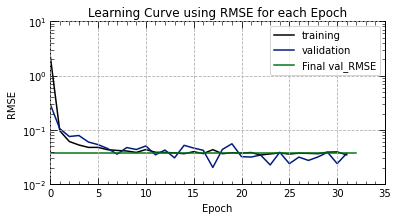

In [10]:
training = Model_fitted.history['loss']
validation = Model_fitted.history['val_loss']

plt.figure(figsize=(6,3))
plt.plot(training, label="training")
plt.plot(validation, label="validation")
plt.plot([0,len(training)],[validation[-1], validation[-1]], label="Final val_RMSE")
plt.yscale("log")
plt.title('Learning Curve using RMSE for each Epoch')
plt.xlabel('Epoch'); plt.ylabel('RMSE')
plt.legend(loc=0); plt.grid(ls="--")

In [11]:
score = Model.evaluate(valInput, valOutput)

9000/9000 [==============================] - 1s 60us/sample - loss: 0.0371 - accuracy: 0.9997


In [12]:
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.03706104468968179
accuracy:  0.9996667


### Predict 

In [13]:
def predict(Model, initialState, sigma, beta, rho):
    """ Predicts and plots states visually """
    LA = LorenzAttractor(t, 
                         initialState=initialState, 
                         sigma=sigma, 
                         beta=beta, 
                         rho=rho)
    X, Y, Z = LA.get_states()
    attractor = np.array([X, Y, Z]).T

    predicted = Model.predict(attractor)

    # plot
    fig = plt.figure(figsize=plt.figaspect(.5))
    gs = GridSpec(3, 2, figure=fig)

    # Set up subplot layout
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[2,0])
    ax4 = fig.add_subplot(gs[:,1], projection='3d')

    axes = (ax1, ax2, ax3, ax4)
    components = ['x', 'y', 'z']

    for indx in range(3): # Calculate and plot new Lines for each component
        axes[indx].plot(LA._t, attractor[:,indx], "k--") # numerical
        axes[indx].plot(LA._t, predicted[:,indx], lw=0.75, color='r') # Predicted
        #axes[indx].plot([int(len(attractor[:,indx])*0.7), int(len(attractor[:,indx])*0.7)], 
        #                 [min(attractor[:,indx]), max(attractor[:,indx])])
        axes[indx].set_ylabel('component: '+str(components[indx]))
        axes[indx].grid(ls='--')

    # plot 3d projection of butterfly
    axes[3].plot(predicted[:,0],
                 predicted[:,1],
                 predicted[:,2],
                 color='r', lw=0.75)

    axes[3].plot(attractor[:, 0],
                 attractor[:, 1],
                 attractor[:, 2],
                 color='k', lw=0.75)


    # Titles
    title = r"Lorenz attractor: $\sigma=${}, $\beta=${}, $\rho=${}"
    axes[3].set_xlabel("X Axis")
    axes[3].set_ylabel("Y Axis")
    axes[3].set_zlabel("Z Axis")
    axes[3].set_title(title.format(str(LA._sigma),str(LA._beta),str(LA._rho)))

    axes[2].set_xlabel('Time')

    plt.show()

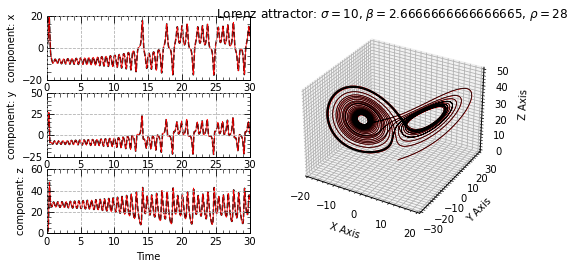

In [14]:
predict(Model, (1.0, 1.0, 1.0), 10, 8/3.0, 28)

Appears to do worse the farther from the critical points of the attractor. Larger orbits seem to do worse as the prediction does not predict the extreme values.

### See how model behaves on differnt shape parameters and initial conditions then attractor model was trained on

In [15]:
testingSigma = np.arange(0, 20, 1)
testingRho = np.arange(0, 20, 1)

testingMesh = np.meshgrid(testingSigma, testingRho)

In [16]:
lossScores = []
for SIGMA in tqdm(testingSigma):
    for RHO in testingRho:
        LA = LorenzAttractor(t, INITIALSTATE, SIGMA, BETA, RHO)
        X, Y, Z = LA.get_states()
        attractor = np.array([X, Y, Z]).T

        lossScores.append(Model.evaluate(attractor[10000:20000], #validation data 
                                         attractor[10000+ndt:20000+ndt], 
                                         verbose = 0)[0]
                         )

  0%|                                                                                                                                                                                                                | 0/20 [00:00<?, ?it/s]C:\Users\Patrick\OneDrive\LorenzAttractor\Lorenz.py:131: UserWarning: No stable critical points
  warnings.warn("No stable critical points")
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:19<00:00,  9.97s/it]


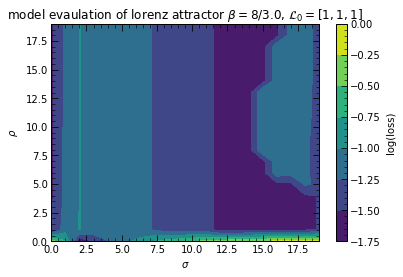

In [17]:
loss = np.asarray(lossScores).reshape(20,20)

fig, ax = plt.subplots()
plot = ax.contourf(testingSigma, testingRho, np.log10(loss))
ax.set_title(r"model evaulation of lorenz attractor $\beta=8/3.0$, $\mathcal{L}_0=[1,1,1]$")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$\rho$")
cbar = fig.colorbar(plot, label="log(loss)")

initialState=(2.0,3.0,10.0), sigma=10, beta=8/3.0, rho=28For a different set of intial conditions on the same parameters as the model was trained on:

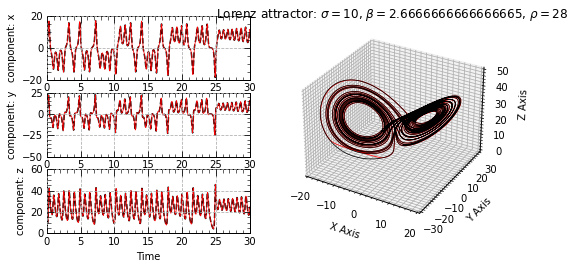

In [18]:
predict(Model, initialState=(2.0,3.0,10.0), sigma=10, beta=8/3.0, rho=28)

Given a different initial condition, the model still did okay for near initial condtions. Lets try a intial state that is faily far away.

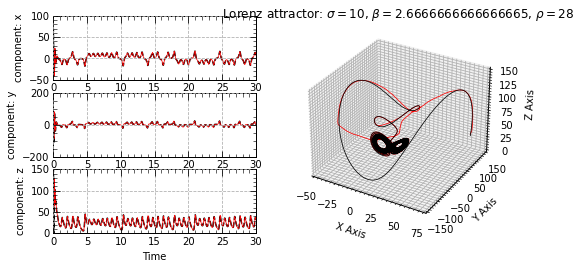

In [19]:
predict(Model, initialState=(64, 128, 30), sigma=10, beta=8/3.0, rho=28)

Not great when the conditons are far away. It seems to settle out when it gets closer to the critical points again. Lets check the loss from initial condions in two dimensions like we did with the physical paramaters.

In [20]:
testingX = np.arange(-40, 40, 2)
testingY = np.arange(-40, 40, 2)

testingMesh = np.meshgrid(testingX, testingY)

lossScores = []
for x in tqdm(testingX):
    for y in testingY:
        initialState= (x, y, 1.0)
        LA = LorenzAttractor(t, initialState, 10, 8/3.0, 28)
        X, Y, Z = LA.get_states()
        attractor = np.array([X, Y, Z]).T

        lossScores.append(Model.evaluate(attractor, #validation data 
                                         attractor, 
                                         verbose = 0)[0]
                         )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [24:38<00:00, 36.96s/it]


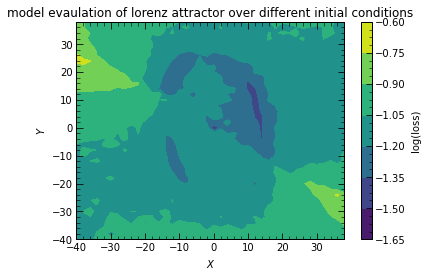

In [21]:
loss = np.asarray(lossScores).reshape(40,40)

fig, ax = plt.subplots()
plot = ax.contourf(testingX, testingY, np.log10(loss))
ax.set_title(r"model evaulation of lorenz attractor over different initial conditions")
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")
cbar = fig.colorbar(plot, label="log(loss)")

The model at $\mathcal{L}=(0,0,0)$ does not do well as states do not progress (trivial case, very different from model). There seems to be a ring region around the point. Lets see what the state progression looks like if we start somewhere in that ring. There are many other interesting patterns in this model evaulation to explore such as the difference between positive and negative initial conditions.

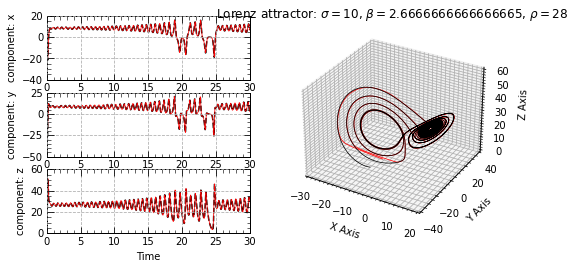

In [22]:
predict(Model, initialState=(-11.0, -15.0, 1.0), sigma=10, beta=8/3.0, rho=28)

The perceptron network does well in predicting close to the training conditions. A set of many differently shaped lorenz attractors while keeping the non-periodic and chaotic properties could help in making the predictions more generalized. This is a sign of over fitting. The attractor has very different shapes depending on the physical parameters. For drastically different shapes and startin conditions the model tends to work well only around the cirtical points.

Another problem with the model was the model tended to undershoot more extreme values of the states.
The next step is to try an RNN network for time series prediction. This would allow for some persistent memory of the states when training the model. RNNs classically do better on time series. It may be more generalized in it's learning as well.